In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context('paper', font_scale=1.75)

# Preparation data

In [2]:
labs = pd.read_csv('data/mimic/labs_first_day.csv', index_col = [0, 1], header = [0, 1])
outcomes = pd.read_csv('data/mimic/outcomes_first_day.csv', index_col = 0)
labs.columns = labs.columns.droplevel() 

In [31]:
# For paper's tables
labs = pd.read_csv('data/mimic/labs_first_day_subselection.csv', index_col = [0, 1])
outcomes = pd.read_csv('data/mimic/outcomes_first_day_subselection.csv', index_col = 0)

### Analysis

In [32]:
labs

Anion gap  Bicarbonate  Blood urea nitrogen  Chloride  \
Patient Time                                                              
3       0.004167        NaN          NaN                  NaN       NaN   
        0.012500       23.0         13.0                 41.0     111.0   
        0.035417       22.0         11.0                 43.0     111.0   
        0.038889        NaN          NaN                  NaN       NaN   
        0.113194        NaN          NaN                  NaN       NaN   
...                     ...          ...                  ...       ...   
99995   0.226389        NaN          NaN                  NaN       NaN   
        0.296528        8.0         34.0                 10.0     100.0   
        0.403472        NaN          NaN                  NaN       NaN   
        0.525000        NaN          NaN                  NaN       NaN   
        0.771528        9.0         32.0                 13.0      99.0   

                  Creatinine  Glucose  Hematocrit  Hemoglobin  Magnesium  \
Patient Time                                                               
3       0.004167         NaN    140.0         NaN         NaN        NaN   
        0.012500         2.4    162.0        24.9         7.8        3.5   
        0.035417         2.5    281.0        25.6         8.2        2.6   
        0.038889         NaN    265.0         NaN         NaN        NaN   
        0.113194         NaN    267.0        30.0        10.1        NaN   
...                      ...      ...         ...         ...        ...   
99995   0.226389         NaN    110.0        27.0         9.0        NaN   
        0.296528         0.4    131.0        26.5         8.7        1.9   
        0.403472         NaN    128.0         NaN         NaN        NaN   
        0.525000         NaN    115.0         NaN         NaN        NaN   
        0.771528         0.5    110.0        28.7         9.3        1.9   

                  Mean corpuscular hemoglobin  \
Patient Time                                    
3       0.004167                          NaN   
        0.012500                         28.9   
        0.035417                         29.6   
        0.038889                          NaN   
        0.113194                          NaN   
...                                       ...   
99995   0.226389                          NaN   
        0.296528                         30.5   
        0.403472                          NaN   
        0.525000                          NaN   
        0.771528                         29.8   

                  Mean corpuscular hemoglobin concentration  \
Patient Time                                                  
3       0.004167                                        NaN   
        0.012500                                       31.3   
        0.035417                                       32.2   
        0.038889                                        NaN   
        0.113194                                        NaN   
...                                                     ...   
99995   0.226389                                        NaN   
        0.296528                                       32.9   
        0.403472                                        NaN   
        0.525000                                        NaN   
        0.771528                                       32.5   

                  Mean corpuscular volume  Platelets  Potassium  \
Patient Time                                                      
3       0.004167                      NaN        NaN        NaN   
        0.012500                     92.0      190.0        4.0   
        0.035417                     92.0      253.0        4.1   
        0.038889                      NaN        NaN        NaN   
        0.113194                      NaN        NaN        NaN   
...                                   ...        ...        ...   
99995   0.226389                      NaN        NaN       

<AxesSubplot:>

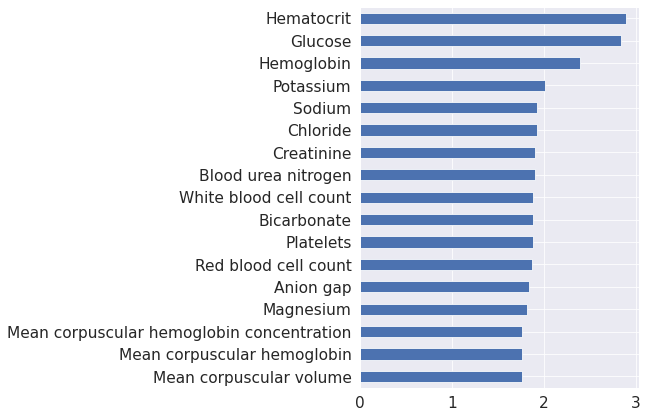

In [33]:
labs.groupby('Patient').count().mean().sort_values()[-20:].plot.barh(figsize = (5,7))

### How many different labs in this period ?

In [34]:
number_events = ((~labs.isna()).sum(axis = 1) > 0).groupby('Patient').sum()
number_events.describe()

count    30834.000000
mean         3.937699
std          3.412225
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         35.000000
dtype: float64

### In hospial mortality

In [35]:
print("In hospital mortality: {:.2f} %".format(100 * (~outcomes.Death.isna()).mean()))

In hospital mortality: 13.86 %


# Analysis per admission day

In [36]:
weekday = [p for p in outcomes.index if outcomes.loc[p].Day <= 4]
weekend = outcomes.index.difference(weekday)

In [37]:
# To modify to study another group
outcome_we = outcomes.loc[weekend]
labs_we = labs.loc[weekend]

outcome_wd = outcomes.loc[weekday]
labs_wd = labs.loc[weekday]

In [38]:
# Prepreocess ethnicity
ethnicity = outcomes.ETHNICITY.copy()
ethnicity[ethnicity.str.contains("ASIAN")] = 'Asian'
ethnicity[ethnicity.str.contains("HISPANIC")] = 'Hispanic'
ethnicity[ethnicity.str.contains("BLACK")] = 'Black'
ethnicity[ethnicity.str.contains("WHITE")] = 'White'
ethnicity[(ethnicity != "Asian") & (ethnicity != "Hispanic") & (ethnicity != "Black") & (ethnicity != "White")] = 'Other'

outcomes.ETHNICITY = ethnicity

In [39]:
los_mean_we = outcome_we['LOS'].mean()
los_std_we = outcome_we['LOS'].std()
los_mean_wd = outcome_wd['LOS'].mean()
los_std_wd = outcome_wd['LOS'].std()
los = pd.DataFrame({'Mean': [outcomes['LOS'].mean(), los_mean_wd, los_mean_we],
                    'Std': [outcomes['LOS'].std(), los_std_wd, los_std_we]}, index = ['Population', 'Weekday', 'Weekend']).T

death_we = (~outcome_we['Death'].isna()).mean()
death_wd = (~outcome_wd['Death'].isna()).mean()
death = pd.DataFrame({'':[(~outcomes['Death'].isna()).mean(), death_wd, death_we]}, index = ['Population', 'Weekday', 'Weekend']).T*100

insurance_we = outcome_we['INSURANCE'].value_counts() / len(outcome_we)
insurance_wd = outcome_wd['INSURANCE'].value_counts() / len(outcome_wd)
insurance = pd.concat({"Population": outcomes['INSURANCE'].value_counts() / len(outcomes), "Weekday": insurance_wd, "Weekend": insurance_we}, 1)*100

ethnicity_we = ethnicity.loc[weekend].value_counts() / len(ethnicity.loc[weekend])
ethnicity_wd = ethnicity.loc[weekday].value_counts() / len(ethnicity.loc[weekday])
ethnicity = pd.concat({"Population": ethnicity.value_counts() / len(ethnicity), "Weekday": ethnicity_wd, "Weekend": ethnicity_we}, 1)*100

gender_we = outcome_we['GENDER'].replace({'M': 'Male', 'F': 'Female'}).value_counts() / len(outcome_we)
gender_wd = outcome_wd['GENDER'].replace({'M': 'Male', 'F': 'Female'}).value_counts() / len(outcome_wd)
gender = pd.concat({"Population": outcomes['GENDER'].replace({'M': 'Male', 'F': 'Female'}).value_counts() / len(outcomes), "Weekday": gender_wd, "Weekend": gender_we}, 1)*100

/tmp/ipykernel_28719/1636578179.py:14: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  insurance = pd.concat({"Population": outcomes['INSURANCE'].value_counts() / len(outcomes), "Weekday": insurance_wd, "Weekend": insurance_we}, 1)*100
/tmp/ipykernel_28719/1636578179.py:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  ethnicity = pd.concat({"Population": ethnicity.value_counts() / len(ethnicity), "Weekday": ethnicity_wd, "Weekend": ethnicity_we}, 1)*100
/tmp/ipykernel_28719/1636578179.py:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  gender = pd.concat({"Population": outcomes['GENDER'].replace({'M': 'Male', 'F': 'Female'}).value_counts() / len(outcomes), "Weekday": gender_wd, "Weekend": gender_we}, 1)*100


In [40]:
analysis = pd.concat({'LOS': los,
           'Death': death,
           'Gender': gender,
           'Ethnicity': ethnicity,
           'Insurance': insurance})
print(analysis.to_latex(float_format="{:0.2f}".format))
analysis

\begin{tabular}{llrrr}
\toprule
          &          &  Population &  Weekday &  Weekend \\
\midrule
LOS & Mean &       10.05 &    10.05 &    10.03 \\
          & Std &       10.49 &    10.60 &    10.15 \\
Death &          &       13.86 &    13.50 &    15.00 \\
Gender & Male &       56.43 &    56.38 &    56.62 \\
          & Female &       43.57 &    43.62 &    43.38 \\
Ethnicity & White &       71.84 &    72.52 &    69.74 \\
          & Other &       14.52 &    14.03 &    16.04 \\
          & Black &        7.88 &     7.87 &     7.92 \\
          & Hispanic &        3.32 &     3.19 &     3.73 \\
          & Asian &        2.43 &     2.39 &     2.57 \\
Insurance & Medicare &       55.02 &    55.04 &    54.94 \\
          & Private &       32.65 &    33.31 &    30.58 \\
          & Medicaid &        8.21 &     7.95 &     9.04 \\
          & Government &        2.92 &     2.69 &     3.61 \\
          & Self Pay &        1.21 &     1.01 &     1.82 \\
\bottomrule
\end{tabular}



Population    Weekday    Weekend
LOS       Mean         10.047194  10.051763  10.032918
          Std          10.491692  10.598973  10.149816
Death                  13.864565  13.502290  14.996656
Gender    Male         56.434455  56.376557  56.615385
          Female       43.565545  43.623443  43.384615
Ethnicity White        71.842771  72.515947  69.739130
          Other        14.519686  14.033135  16.040134
          Black         7.884154   7.872769   7.919732
          Hispanic      3.321009   3.189349   3.732441
          Asian         2.432380   2.388801   2.568562
Insurance Medicare     55.017189  55.040884  54.943144
          Private      32.645781  33.306220  30.581940
          Medicaid      8.214958   7.949827   9.043478
          Government    2.915613   2.692752   3.612040
          Self Pay      1.206460   1.010317   1.819398

In [41]:
count_mean = labs.groupby('Patient').count().mean()
count_std = labs.groupby('Patient').count().std()
value_mean = labs.groupby('Patient').mean().mean()
value_std = labs.groupby('Patient').mean().std()

In [42]:
tests = pd.DataFrame({('Number Test', 'Mean'): count_mean,
           ('Number Test', 'Std'):count_std, 
           ('Value', 'Mean'): value_mean, 
           ('Value', 'Std'): value_std})
print(tests.to_latex(float_format="{:0.2f}".format))
tests

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{Number Test} & \multicolumn{2}{l}{Value} \\
{} &        Mean &  Std &   Mean &    Std \\
\midrule
Anion gap                                 &        1.84 & 1.00 &  13.87 &   3.23 \\
Bicarbonate                               &        1.88 & 1.00 &  24.15 &   4.34 \\
Blood urea nitrogen                       &        1.90 & 1.00 &  24.91 &  20.36 \\
Chloride                                  &        1.92 & 1.03 & 105.09 &   5.74 \\
Creatinine                                &        1.91 & 1.00 &   1.33 &   1.38 \\
Glucose                                   &        2.84 & 2.59 & 136.77 &  49.89 \\
Hematocrit                                &        2.89 & 2.36 &  32.89 &   5.34 \\
Hemoglobin                                &        2.39 & 2.04 &  11.09 &   1.91 \\
Magnesium                                 &        1.81 & 0.97 &   1.98 &   0.37 \\
Mean corpuscular hemoglobin               &        1.76 & 0.96 &  30.29 &   2.52 \\
Mean c

Number Test                 Value  \
                                                 Mean       Std        Mean   
Anion gap                                    1.840371  0.999437   13.869923   
Bicarbonate                                  1.881916  0.999677   24.148677   
Blood urea nitrogen                          1.899202  0.997560   24.909690   
Chloride                                     1.924888  1.033322  105.093400   
Creatinine                                   1.907148  1.001947    1.332760   
Glucose                                      2.835279  2.585949  136.765185   
Hematocrit                                   2.885938  2.363861   32.894538   
Hemoglobin                                   2.391743  2.036679   11.092072   
Magnesium                                    1.813874  0.974504    1.977925   
Mean corpuscular hemoglobin                  1.763735  0.959191   30.291711   
Mean corpuscular hemoglobin concentration    1.764546  0.960353   33.821806   
Mean corpuscular volume                      1.763702  0.959200   89.634972   
Platelets                                    1.877019  1.101764  224.067564   
Potassium                                    2.012129  1.084613    4.129046   
Red blood cell count                         1.873711  1.017956    5.229203   
Sodium                                       1.925796  1.075978  138.885875   
White blood cell count                       1.882792  1.026936   11.829122   

                                                       
                                                  Std  
Anion gap                                    3.231425  
Bicarbonate                                  4.337579  
Blood urea nitrogen                         20.364037  
Chloride                                     5.741834  
Creatinine                                   1.382894  
Glucose                                     49.888459  
Hematocrit                                   5.341575  
Hemoglobin                                   1.914476  
Magnesium                                    0.365073  
Mean corpuscular hemoglobin                  2.516747  
Mean corpuscular hemoglobin concentration    1.524732  
Mean corpuscular volume                      6.645902  
Platelets                                  109.734915  
Potassium                                    0.553763  
Red blood cell count                        15.238940  
Sodium                                       4.377901  
White blood cell count                      13.084083

In [43]:
count_mean_we = labs_we.groupby('Patient').count().mean()
count_std_we = labs_we.groupby('Patient').count().std()
value_mean_we = labs_we.groupby('Patient').mean().mean()
value_std_we = labs_we.groupby('Patient').mean().std()

count_mean_wd = labs_wd.groupby('Patient').count().mean()
count_std_wd = labs_wd.groupby('Patient').count().std()
value_mean_wd = labs_wd.groupby('Patient').mean().mean()
value_std_wd = labs_wd.groupby('Patient').mean().std()

In [44]:
import scipy.stats

In [45]:
tests = pd.DataFrame({('Number Test', 'Weekday', 'Mean'): count_mean_wd, 
            ('Number Test', 'Weekend', 'Mean'): count_mean_we, 
            ('Number Test', 'Test', 'P Value'): [scipy.stats.ttest_ind(labs_we[i].groupby('Patient').count().dropna(), labs_wd[i].groupby('Patient').count().dropna())[1] for i in labs_wd.columns],
           ('Value', 'Weekday', 'Mean'): value_mean_wd, 
           ('Value', 'Weekend', 'Mean'): value_mean_we,
           ('Value', 'Test', 'P Value'): [scipy.stats.ttest_ind(labs_we[i].groupby('Patient').mean().dropna(), labs_wd[i].groupby('Patient').mean().dropna())[1] for i in labs_wd.columns],
           
          })
print(tests.loc[labs.groupby('Patient').count().mean().sort_values().index].to_latex(float_format="{:0.3f}".format))
tests

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Number Test} & \multicolumn{3}{l}{Value} \\
{} &     Weekday & Weekend &    Test & Weekday & Weekend &    Test \\
{} &        Mean &    Mean & P Value &    Mean &    Mean & P Value \\
\midrule
Mean corpuscular volume                   &       1.786 &   1.694 &   0.000 &  89.587 &  89.786 &   0.024 \\
Mean corpuscular hemoglobin               &       1.786 &   1.694 &   0.000 &  30.288 &  30.302 &   0.680 \\
Mean corpuscular hemoglobin concentration &       1.787 &   1.695 &   0.000 &  33.837 &  33.776 &   0.003 \\
Magnesium                                 &       1.807 &   1.834 &   0.038 &   1.982 &   1.964 &   0.000 \\
Anion gap                                 &       1.835 &   1.857 &   0.101 &  13.800 &  14.090 &   0.000 \\
Red blood cell count                      &       1.896 &   1.805 &   0.000 &   5.173 &   5.406 &   0.248 \\
Platelets                                 &       1.906 &   1.786 &   0.000 & 223.470 & 225.936

Number Test                          \
                                              Weekday   Weekend          Test   
                                                 Mean      Mean       P Value   
Anion gap                                    1.835096  1.856856  1.013302e-01   
Bicarbonate                                  1.886297  1.868227  1.737791e-01   
Blood urea nitrogen                          1.905304  1.880134  5.759565e-02   
Chloride                                     1.932531  1.901003  2.167134e-02   
Creatinine                                   1.913781  1.886421  3.989352e-02   
Glucose                                      3.000385  2.319331  5.829763e-88   
Hematocrit                                   3.013357  2.487759  4.057904e-63   
Hemoglobin                                   2.513892  2.010033  8.861097e-78   
Magnesium                                    1.807355  1.834247  3.782939e-02   
Mean corpuscular hemoglobin                  1.786078  1.693913  4.704367e-13   
Mean corpuscular hemoglobin concentration    1.786763  1.695117  6.765546e-13   
Mean corpuscular volume                      1.785993  1.694047  5.343079e-13   
Platelets                                    1.906118  1.786087  2.353858e-16   
Potassium                                    2.010360  2.017659  6.125816e-01   
Red blood cell count                         1.895672  1.805084  2.098899e-11   
Sodium                                       1.923627  1.932575  5.314325e-01   
White blood cell count                       1.903506  1.818060  3.772571e-10   

                                                Value              \
                                              Weekday     Weekend   
                                                 Mean        Mean   
Anion gap                                   13.799624   14.089602   
Bicarbonate                                 24.190642   24.017539   
Blood urea nitrogen                         24.818180   25.195654   
Chloride                                   105.113789  105.029685   
Creatinine                                   1.332751    1.332786   
Glucose                                    137.095694  135.732361   
Hematocrit                                  32.810782   33.156269   
Hemoglobin                                  11.062424   11.184720   
Magnesium                                    1.982267    1.964358   
Mean corpuscular hemoglobin                 30.288369   30.302153   
Mean corpuscular hemoglobin concentration   33.836501   33.775887   
Mean corpuscular volume                     89.586675   89.785899   
Platelets                                  223.469513  225.936442   
Potassium                                    4.143859    4.082756   
Red blood cell count                         5.172547    5.406249   
Sodium                                     138.848684  139.002093   
White blood cell count                      11.840445   11.793739   

                                                         
                                                   Test  
                                                P Value  
Anion gap                                  1.426475e-11  
Bicarbonate                                2.670833e-03  
Blood urea nitrogen                        1.630520e-01  
Chloride                                   2.703584e-01  
Creatinine                                 9.985047e-01  
Glucose                                    3.973658e-02  
Hematocrit                                 1.127162e-06  
Hemoglobin                                 1.525444e-06  
Magnesium                                  2.227714e-04  
Mean corpuscular hemoglobin                6.802396e-01  
Mean corpuscular hemoglobin concentration  2.774618e-03  
Mean corpuscular volume                    2.407920e-02  
Platelets                                  9.069894e-02  
Potassium                                  9.745725e-17  
Red blood cell count                       2.484835e-0

In [46]:
ordered_test = labs.groupby('Patient').count().sum(1).to_frame(name = 'Total tests ordered').join(
    (outcomes.Day <= 4).rename("Admission").replace({False: "Weekend", True: "Weekday"})
    ).join(outcomes.Death.isna().rename("Outcome").replace({True: "Discharge", False: "Death"}))

(20.0, 70.0)

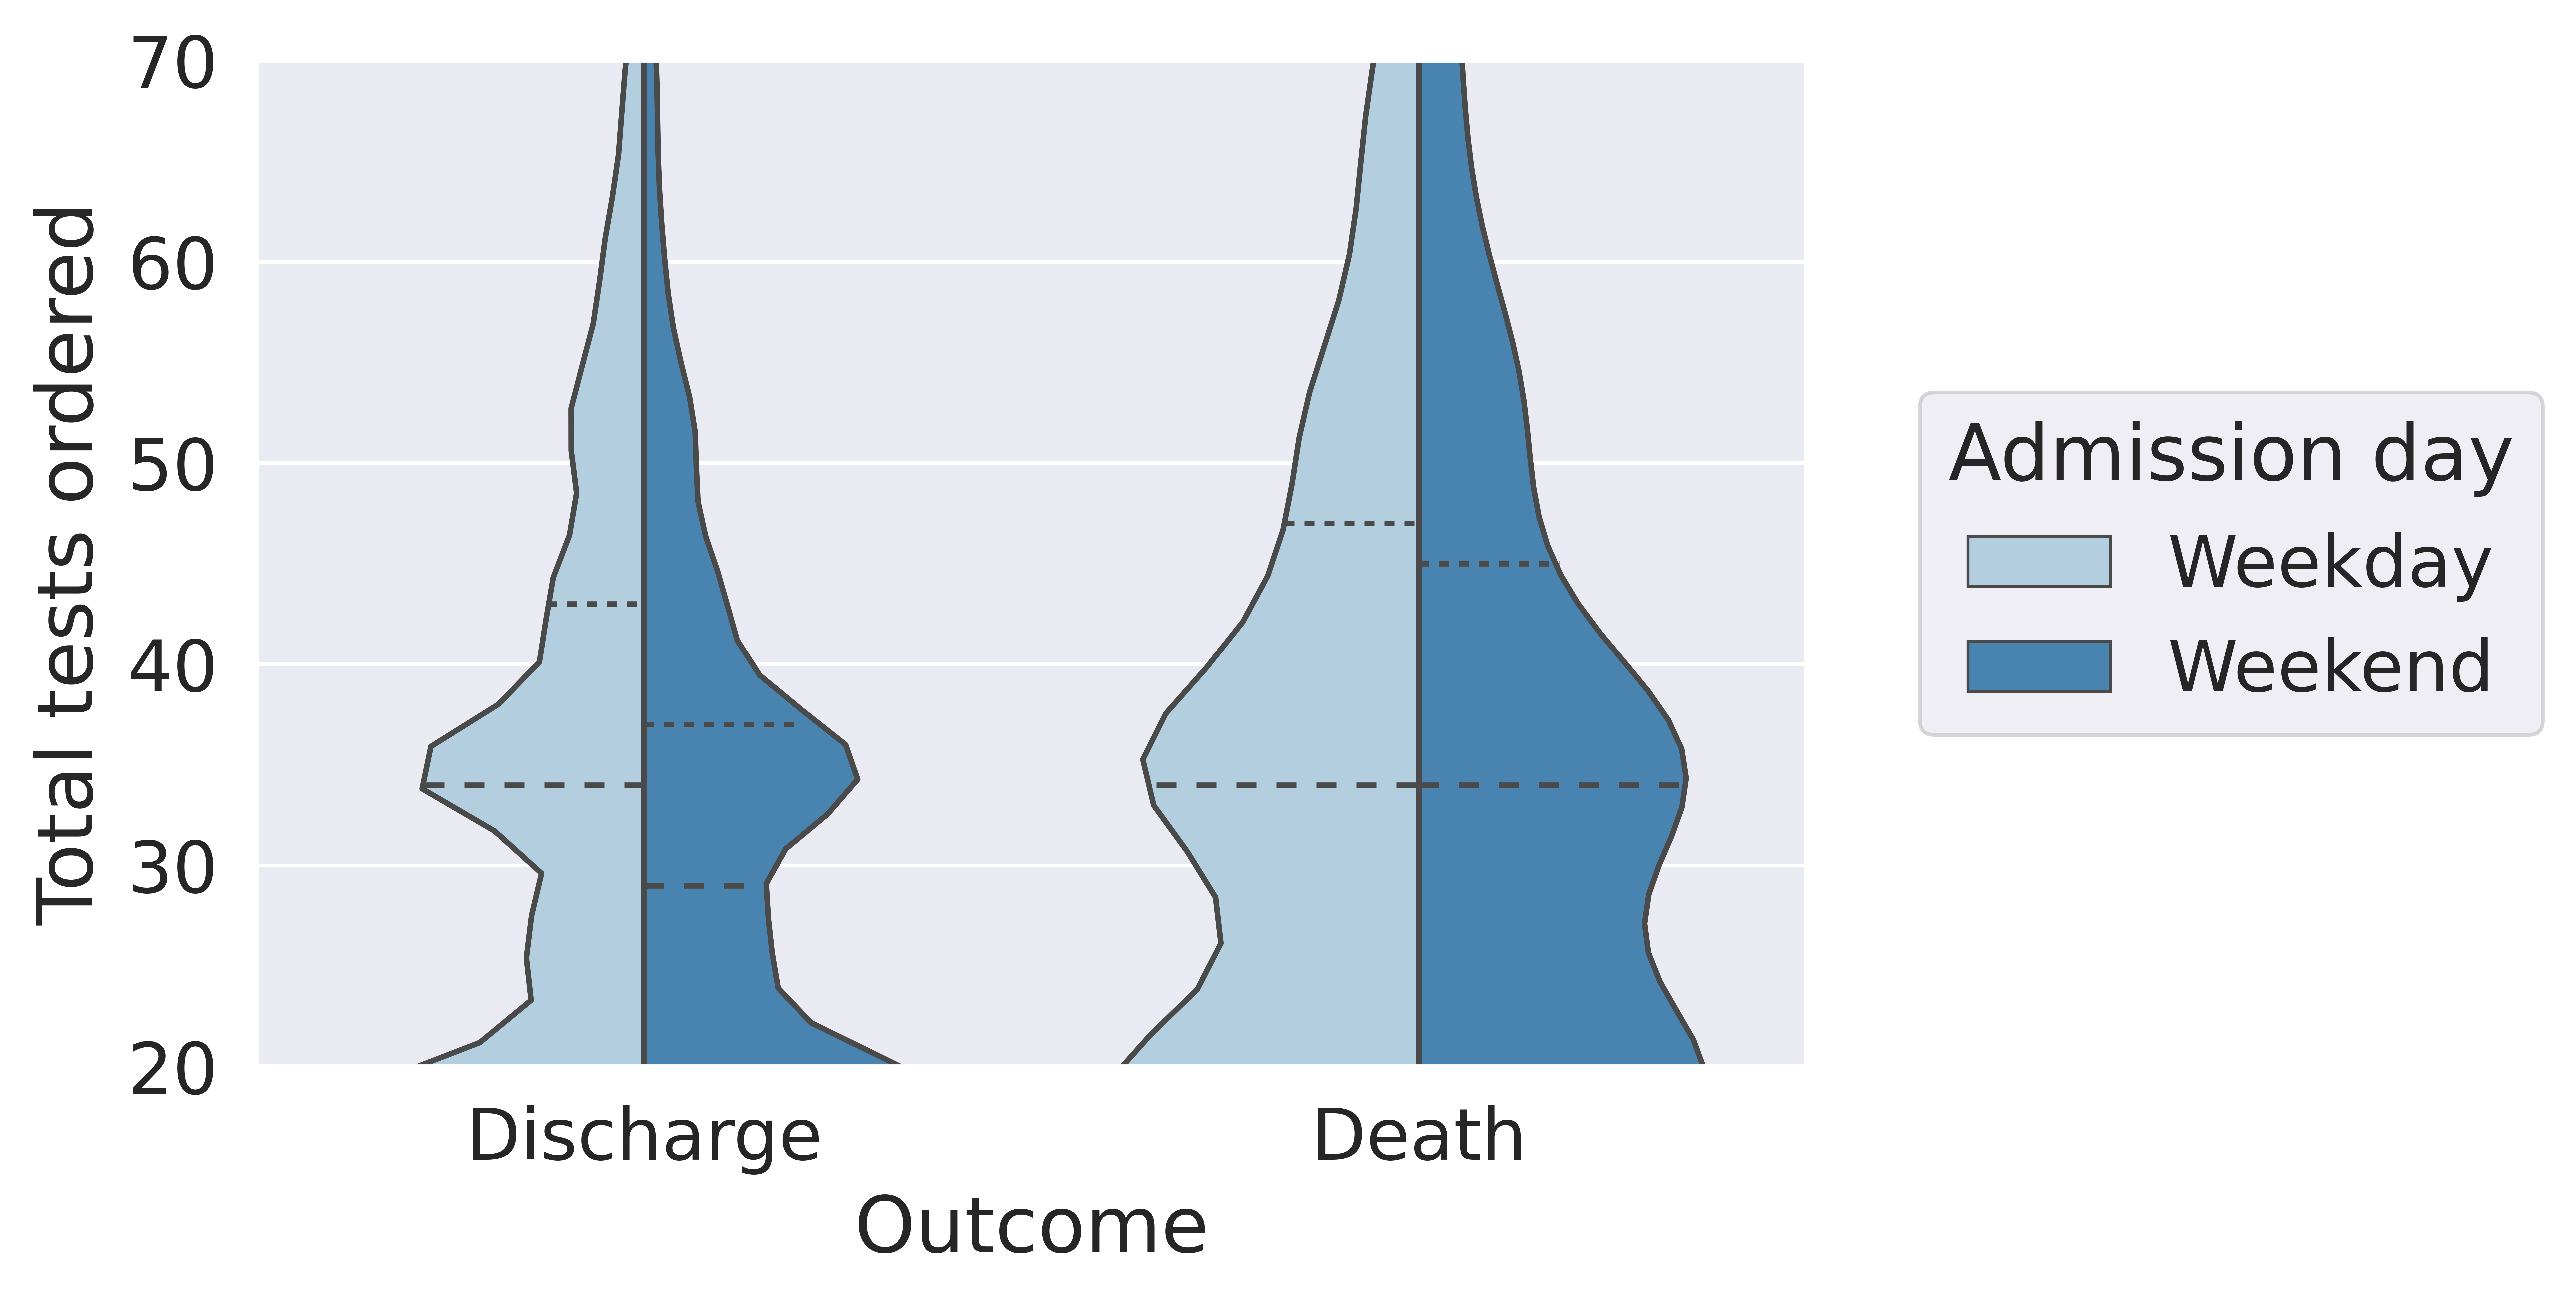

In [52]:
plt.figure(dpi = 1000)
ax = sns.violinplot(x = "Outcome", y = "Total tests ordered", hue = 'Admission', data = ordered_test, split = True, inner = 'quartile', palette = "Blues", cut = 0, fig_size = (10,5))
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title = 'Admission day')
plt.ylim(20, 70)

# Analyze available labs

Subselect features to use.

In [ ]:
from FeatureAnalysis.analysis.eclat import eclat
from FeatureAnalysis.analysis.rendering import buildGraph

In [ ]:
missing_data = labs.groupby('Patient').count()
missing_data[missing_data <= 0] = np.nan
missing_data[0 < missing_data] = 1

In [ ]:
features = eclat(missing_data, minCount = 30000)
print(features)
buildGraph(features, mainBranch = True).render('examples/small')

In [ ]:
def next_feature(node):
    if len(node.children) == 0:
        return [node.name]
    return [node.name] + next_feature(node.children[0])

In [ ]:
# Remove patients with no values
selection = labs[next_feature(features.children[0])][next_feature(features.children[0])]
selection = (selection.groupby('Patient').count() == 0).sum(1) == 0
selection = selection.index[selection]

In [ ]:
labs[labs.index.get_level_values('Patient').isin(selection)][next_feature(features.children[0])]

In [ ]:
labs_subselection = labs[labs.index.get_level_values('Patient').isin(selection)][next_feature(features.children[0])].dropna(how = 'all')
outcomes_subselection = outcomes[outcomes.index.get_level_values('Patient').isin(labs_subselection.index.get_level_values('Patient'))]

In [ ]:
# Save subsets patients and labs
labs_subselection.to_csv('data/mimic/labs_first_day_subselection.csv')
outcomes_subselection.to_csv('data/mimic/outcomes_first_day_subselection.csv')

# Display observation process

Display a random selection for each outcomes of the observation process

In [ ]:
np.random.seed(42)

In [ ]:
n = 30
random_selection = {
    time: 
        {
            'Early Death\n(before end of week 1)': outcomes_time[(~outcomes_time.Death.isna()) & (outcomes_time.LOS < 7)].sample(n = n),
            'Later Death': outcomes_time[(~outcomes_time.Death.isna()) & (outcomes_time.LOS > 7)].sample(n = n),
            'Discharged': outcomes_time[outcomes_time.Death.isna()].sample(n = n) 
        } for time, outcomes_time in zip(['Weekday Admission', 'Weekend Admission'], [outcome_wd, outcome_we])
    }



In [ ]:
for l in np.random.choice(labs.columns, size = 5):
    labs_display = labs[l].dropna()

    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 8), sharex = True, sharey = True)
    fig.suptitle(l)

    for j, time in enumerate(random_selection.keys()):
        ax[0, j].set_title(time)
        for i, cat in enumerate(random_selection[time].keys()):
            ax[i, j].axes.yaxis.set_ticks([])
            ax[i, j].set_xlim([0, 24])
            ax[i, 0].set_ylabel(cat)
            for k, patient in enumerate(random_selection[time][cat].index):
                ax[i, j].plot([0, 24], [k, k], ls = '--', alpha = 0.5, c = 'w')
                try:
                    data_patient = labs_display.loc[patient].index
                    ax[i, j].scatter(24 * data_patient, [k] * len(data_patient), alpha = 0.8, marker = 'x')
                except:
                    pass
    ax[-1, 1].set_xlabel('Time (in hours)')
    ax[-1, 0].set_xlabel('Time (in hours)')
    plt.tight_layout()
    plt.show()